In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# -------------------------------
# 1. Utility: Load and visualize
# -------------------------------

def load_image(path):
    """Load a BGR image from disk."""
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {path}")
    return img


def show_image(title, img, cmap=None, size=(6, 4)):
    """Helper to show an image with matplotlib."""
    plt.figure(figsize=size)
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap=cmap or "gray")
    else:  # BGR -> RGB
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [10]:
# ---------------------------------------------
# 2. Gradients: Sobel, magnitude, orientation
# ---------------------------------------------

def compute_gradients(gray):
    """Compute Sobel gradients, magnitude and direction."""
    Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(Gx ** 2 + Gy ** 2)
    direction = np.arctan2(Gy, Gx)

    return Gx, Gy, magnitude, direction


def show_gradients(magnitude, direction):
    """Visualize gradient magnitude and direction."""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap="gray")
    plt.title("Gradient Magnitude")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(direction, cmap="hsv")
    plt.title("Gradient Direction")
    plt.axis("off")

    plt.show()



In [11]:

# -----------------------------------
# 3. Edge detection: Sobel & Canny
# -----------------------------------

def sobel_edge_detection(gray):
    edges_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=3)
    return np.abs(edges_sobel)


def canny_edge_detection(gray, low_thresh=50, high_thresh=150):
    return cv2.Canny(gray, low_thresh, high_thresh)


In [12]:
# --------------------------------------------
# 4. Region of Interest (Trapezoid Mask)
# --------------------------------------------

def region_of_interest(edges):
    """
    Apply a trapezoid mask to keep only the lane region.
    Assumes forward-facing road image.
    """
    height, width = edges.shape

    vertices = np.array([[
        (int(0.1 * width), height),            # bottom-left
        (int(0.45 * width), int(0.6 * height)),  # top-left
        (int(0.55 * width), int(0.6 * height)),  # top-right
        (int(0.9 * width), height)             # bottom-right
    ]], dtype=np.int32)

    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)

    roi_edges = cv2.bitwise_and(edges, mask)
    return roi_edges, vertices



In [13]:
# --------------------------------------------
# 5. Lane detection with Hough Transform
# --------------------------------------------

def make_line_points(slope, intercept, height):
    """Compute two points on a line (for drawing) given slope/intercept."""
    y1 = height
    y2 = int(height * 0.6)
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return x1, y1, x2, y2


def detect_lanes_hough(edges, orig_img):
    """
    Use HoughLinesP on ROI edges, separate left/right lanes,
    average them, and draw on a copy of the original image.
    """
    height, width = edges.shape
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=50,
        minLineLength=80,
        maxLineGap=50
    )

    left_params = []
    right_params = []

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if x2 - x1 == 0:
                continue  # avoid division by zero

            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1

            # Filter out nearly horizontal lines
            if abs(slope) < 0.5:
                continue

            if slope < 0:
                left_params.append((slope, intercept))
            else:
                right_params.append((slope, intercept))

    lane_img = orig_img.copy()

    if left_params:
        left_avg = np.mean(left_params, axis=0)
        lx1, ly1, lx2, ly2 = make_line_points(left_avg[0], left_avg[1], height)
        cv2.line(lane_img, (lx1, ly1), (lx2, ly2), (0, 255, 0), 6)

    if right_params:
        right_avg = np.mean(right_params, axis=0)
        rx1, ry1, rx2, ry2 = make_line_points(right_avg[0], right_avg[1], height)
        cv2.line(lane_img, (rx1, ry1), (rx2, ry2), (0, 255, 0), 6)

    return lane_img

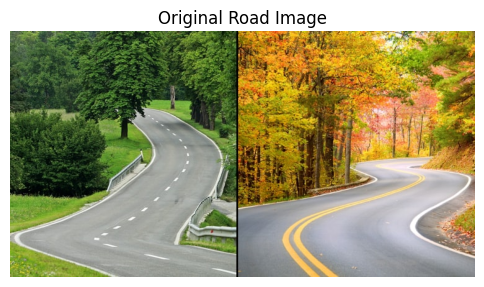

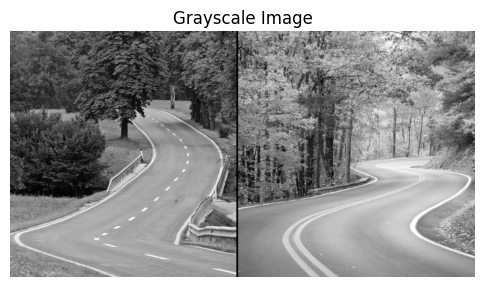

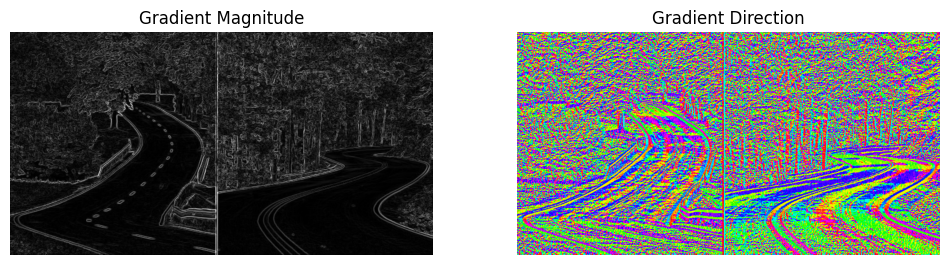

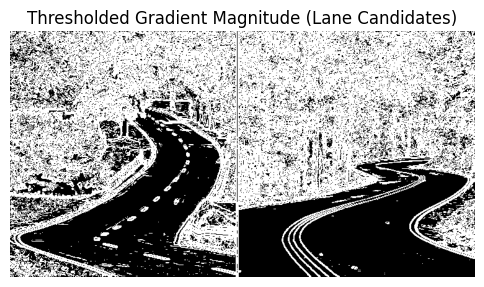

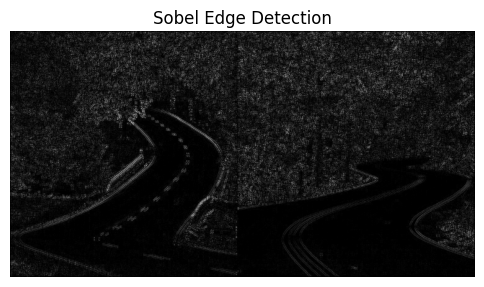

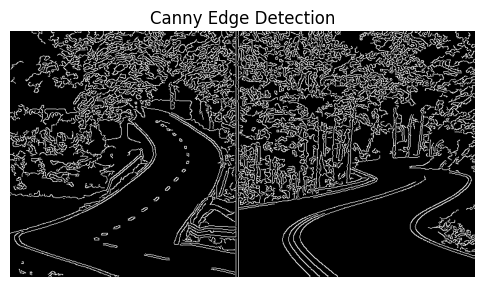

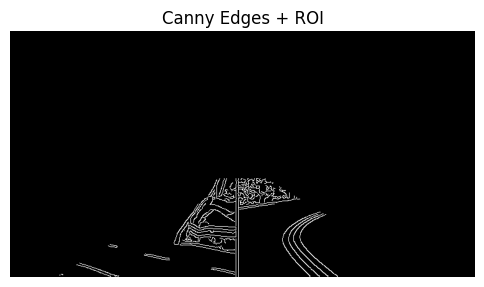

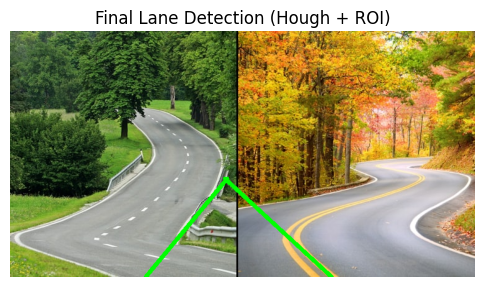

Pipeline complete ✅


In [14]:
# --------------------------------------------
# 6. End-to-end pipeline
# --------------------------------------------

def run_pipeline(image_path):
    # Load image
    img = load_image(image_path)
    show_image("Original Road Image", img)

    # Grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    show_image("Grayscale Image", gray, cmap="gray")

    # Gradients
    Gx, Gy, magnitude, direction = compute_gradients(gray)
    show_gradients(magnitude, direction)

    # Thresholded magnitude (simple lane/edge highlight)
    _, lane_edges_mag = cv2.threshold(magnitude, 50, 255, cv2.THRESH_BINARY)
    lane_edges_mag = np.uint8(lane_edges_mag)
    show_image("Thresholded Gradient Magnitude (Lane Candidates)",
               lane_edges_mag, cmap="gray")

    # Sobel & Canny edges
    sobel_edges = sobel_edge_detection(gray)
    show_image("Sobel Edge Detection", sobel_edges, cmap="gray")

    canny_edges = canny_edge_detection(blur, 50, 150)
    show_image("Canny Edge Detection", canny_edges, cmap="gray")

    # ROI + Hough lane detection
    roi_edges, vertices = region_of_interest(canny_edges)
    show_image("Canny Edges + ROI", roi_edges, cmap="gray")

    lane_img = detect_lanes_hough(roi_edges, img)
    show_image("Final Lane Detection (Hough + ROI)", lane_img)

    print("Pipeline complete ✅")


if __name__ == "__main__":
    # TODO: replace the path below with YOUR image path
    image_path = r"C:\Users\akank\OneDrive\Documents\Akanksha\betch\5th sem\yellow-and-white-road-markings.jpg"
    run_pipeline(image_path)